In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
results_dir = './tables/formatted/'

**Experiment Setup Parameters:**

Spatial Deviation of Anomaly:

$d \in \{0, 1, 2\}$

Ratio of anomalous trajectories in test set:

$r \in \{0.05, 0.1\}$

Ratio of deviating points in trajectory:

$\rho \in \{0.05, 0.1, 0.2\}$

# RQ: 1 Optimal GMM Components
How does the number of Gaussian mixture components contribute to reducing false positive rates when distinguishing weather-induced movements from artificial anomalies?

## Methods

In [ ]:
def create_styled_plot(
    data,
    x_col='C',
    y_col='roc_auc_score',
    group_col='type',
    figsize=(8, 6),
    colors=['b', 'orange', 'r'],
    markers=['v', 'o', '^'],
    linestyles=['-', '--', '-.'],
    linewidth=2,
    markersize=6,
    xlabel='Number of Gaussian Components',
    ylabel='ROC-AUC',
    xlim=(0, 105),
    ylim=(0.4, 0.85),
    xticks=[1, 5, 10, 20, 25, 30, 40, 50, 100],
    grid=True,
    grid_alpha=0.3,
    grid_axis='y',
    legend_fontsize=11,
    legend_labels=['Shift Deviation', 'Abnormal Heading', 'Abnormal Speed'],
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    title_fontsize=14,
    title=None,
    save_path=None,
    save_format='pdf',
    dpi=300,
    show_plot=True,
    tight_layout=True,
    print_stats=False
):


    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Create pivot table with x_col as index and group_col as columns
    pivot_data = data.pivot_table(
        values=y_col,
        index=x_col,
        columns=group_col,
        aggfunc='mean'
    )

    # Plot each column (group) from the pivot table
    for i, col in enumerate(pivot_data.columns):
        ax.plot(
            pivot_data.index,
            pivot_data[col],
            marker=markers[i % len(markers)],
            color=colors[i % len(colors)],
            linestyle=linestyles[i % len(linestyles)],
            linewidth=linewidth,
            markersize=markersize,
            label=f'Group {col}'  # Default label, will be overridden by legend_labels
        )

    # Customize the plot
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)

    # Set grid
    if grid:
        ax.grid(True, alpha=grid_alpha, axis=grid_axis)

    # Set axis limits
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # Set x-axis ticks
    if xticks:
        ax.set_xticks(xticks)

    # Add legend
    if legend_labels and len(legend_labels) >= len(pivot_data.columns):
        ax.legend(fontsize=legend_fontsize, labels=legend_labels[:len(pivot_data.columns)])
    else:
        ax.legend(fontsize=legend_fontsize)

    # Add title if provided
    if title:
        ax.set_title(title, fontsize=title_fontsize)

    # Apply tight layout
    if tight_layout:
        plt.tight_layout()

    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, format=save_format, dpi=dpi, bbox_inches='tight')

    # Print statistics if requested
    if print_stats:
        print("Data overview:")
        print(f"{x_col} values range: {data[x_col].min()} to {data[x_col].max()}")
        print(f"Available {group_col} values: {sorted(data[group_col].unique())}")
        print(f"\nMean {y_col} by {x_col} and {group_col}:")
        print(pivot_data)

    # Show the plot if requested
    if show_plot:
        plt.show()

    return fig, ax

## Data loading

In [4]:
data_dir = '../experiment-results/tables/components/cfs_youden/'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = {f: pd.read_csv(data_dir+f).drop('Unnamed: 0', axis=1) for f in files}

In [5]:
for fn, df in dfs.items():
  fn = fn.replace('.csv', '')
  df['C'] = int(fn)

In [6]:
results = pd.concat(dfs.values(), axis=0)
results['d'] = results['d'].fillna(0.0).astype('int')

results['accuracy'] = (results['tn'] + results['tp']) / (results['tn'] + results['tp'] + results['fn'] + results['fp'])
results['sensitivity'] = 1 - results['fnr']
results['specificity'] = 1 - results['fpr']

## Data Selection
Because we test the discriminative capabilities of the model by setting the spatial deviation to the smalles value:

$d = 1 $ (For anomalies of type 1 and 2)

we must ensure equal representation of the different types of anomalies. We set the experiment parameters to:

$r \in \{0.1\}$

$\rho \in \{0.05\}$

Resulting in equally weighted test results

In [7]:
results_selected = results[(results['d'].isin([0, 1])) & (results['r'].isin([0.1])) & (results['p'].isin([0.05]))]
results_selected = results_selected[results_selected['C'] != 25] # Run for 25 GMM components did only train for 97 epochs

In [8]:
results_selected

,type,d,r,p,roc_auc_score,threshold,tn,fp,fn,tp,fpr,fnr,precision,recall,f1_score,C,accuracy,sensitivity,specificity
3,1,1,0.1,0.05,0.575724,24.683228,587,155,47,33,0.208895,0.587500,0.175532,0.412500,0.246269,1,0.754258,0.412500,0.791105
12,2,1,0.1,0.05,0.504944,20.567661,300,440,27,55,0.594595,0.329268,0.111111,0.670732,0.190641,1,0.431873,0.670732,0.405405
21,3,0,0.1,0.05,0.603707,19.810751,247,485,12,69,0.662568,0.148148,0.124549,0.851852,0.217323,1,0.388684,0.851852,0.337432
3,1,1,0.1,0.05,0.570889,22.281851,437,305,31,49,0.411051,0.387500,0.138418,0.612500,0.225806,10,0.591241,0.612500,0.588949
12,2,1,0.1,0.05,0.500775,20.289909,289,451,28,54,0.609459,0.341463,0.106931,0.658537,0.183986,10,0.417275,0.658537,0.390541
21,3,0,0.1,0.05,0.593082,19.135424,220,512,10,71,0.699454,0.123457,0.121784,0.876543,0.213855,10,0.357934,0.876543,0.300546
3,1,1,0.1,0.05,0.465751,28.434149,724,18,75,5,0.024259,0.937500,0.217391,0.062500,0.097087,100,0.886861,0.062500,0.975741
12,2,1,0.1,0.05,0.495188,22.209009,382,358,38,44,0.483784,0.463415,0.109453,0.536585,0.181818,100,0.518248,0.536585,0.516216
21,3,0,0.1,0.05,0.622445,21.522238,316,416,17,64,0.568306,0.209877,0.133333,0.790123,0.228164,100,0.467405,0.790123,0.431694
3,1,1,0.1,0.05,0.547423,23.785801,521,221,46,34,0.297844,0.575000,0.133333,0.425000,0.202985,20,0.675182,0.425000,0.702156


### Representation Table
Shows equal representation of the anomalies used for assessment

In [9]:
results_selected.groupby(['C', 'type'])['d'].count()

C    type
1    1       1
     2       1
     3       1
5    1       1
     2       1
     3       1
10   1       1
     2       1
     3       1
20   1       1
     2       1
     3       1
30   1       1
     2       1
     3       1
40   1       1
     2       1
     3       1
50   1       1
     2       1
     3       1
100  1       1
     2       1
     3       1
Name: d, dtype: int64

## ROC AUC

### Table Scores ROC AUC

In [10]:
gb_rocauc = results_selected.groupby('C')['roc_auc_score'].mean()
print(f'Largest ROC AUC score for C = {gb_rocauc.idxmax()}')
gb_rocauc

Largest ROC AUC score for C = 5


C
1      0.561458
5      0.566001
10     0.554915
20     0.553252
30     0.551671
40     0.553978
50     0.556365
100    0.527795
Name: roc_auc_score, dtype: float64

## Create Plot ROC AUC

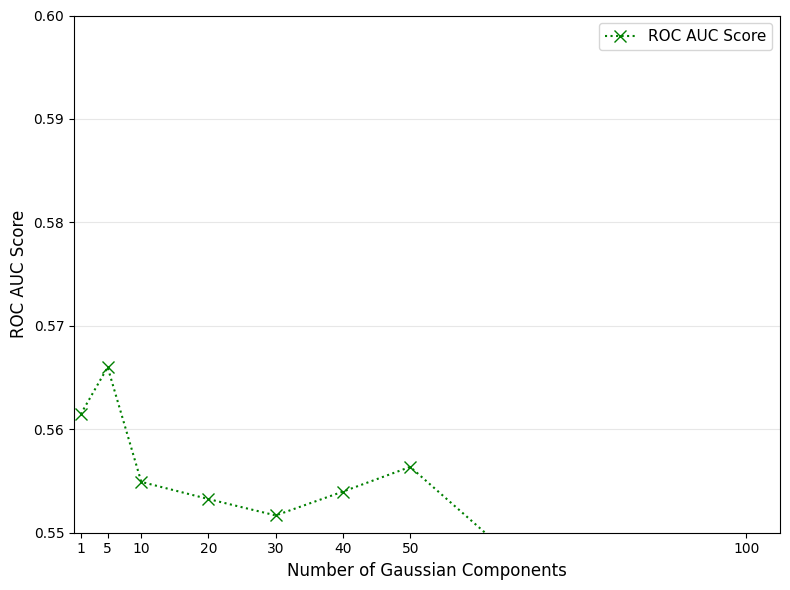

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Number of Gaussian Components', ylabel='ROC AUC Score'>)

In [ ]:
create_styled_plot(
    results_selected,
    x_col='C',
    y_col='roc_auc_score',
    group_col=None,
    figsize=(8, 6),
    colors=['green'],
    markers=['x'],
    linestyles=['dotted'],
    linewidth=1.5,
    markersize=8,
    xlabel='Number of Gaussian Components',
    ylabel='ROC AUC Score',
    xlim=(0, 105),
    ylim=(0.55, 0.6),
    xticks=[1, 5, 10, 20, 30, 40, 50, 100],
    grid=True,
    grid_alpha=0.3,
    grid_axis='y',
    legend_fontsize=11,
    legend_labels=['ROC AUC Score'],#['Shift Deviation', 'Abnormal Heading', 'Abnormal Speed'],
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    title_fontsize=14,
    title=None,
    # save_path='plots/RQ1/ROC-AUC.pdf',
    save_format='pdf',
    dpi=300,
    show_plot=True,
    tight_layout=True,
    print_stats=False
)

## Sensitivity

### Scores Table

In [12]:
gb_sens = results_selected.groupby('C')['sensitivity'].mean()
print(f'Largest sensitivity score for C = {gb_sens.idxmax()}')
gb_sens

Largest sensitivity score for C = 10


C
1      0.645028
5      0.612977
10     0.715860
20     0.571206
30     0.620945
40     0.535131
50     0.636597
100    0.463070
Name: sensitivity, dtype: float64

### Create Plot

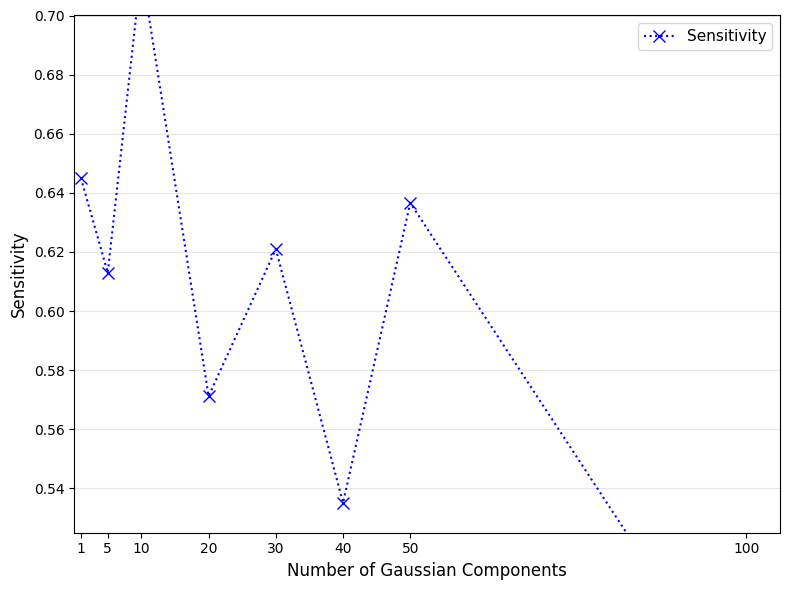

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Number of Gaussian Components', ylabel='Sensitivity'>)

In [ ]:
create_styled_plot(
    results_selected,
    x_col='C',
    y_col='sensitivity',
    group_col=None,
    figsize=(8, 6),
    colors=['b'],
    markers=['x'],
    linestyles=['dotted'],
    linewidth=1.5,
    markersize=8,
    xlabel='Number of Gaussian Components',
    ylabel='Sensitivity',
    xlim=(0, 105),
    ylim=(0.525, 0.7),
    xticks=[1, 5, 10, 20, 30, 40, 50, 100],
    grid=True,
    grid_alpha=0.3,
    grid_axis='y',
    legend_fontsize=11,
    legend_labels=['Sensitivity'],
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    title_fontsize=14,
    title=None,
    #save_path='plots/RQ1/sensitivity.pdf',
    save_format='pdf',
    dpi=300,
    show_plot=True,
    tight_layout=True,
    print_stats=False
)

## ROC AUC Sensitivity Specificy Combined

### Table Scores Combined

In [15]:
gb = results_selected.groupby('C')[['roc_auc_score', 'sensitivity', 'specificity']].mean()
# gb.to_csv('tables/RQ1/roc-auc-combined.csv', float_format='%.4f')
print(f'Best values for C per metric:\n\n{gb.idxmax()}')

Best values for C per metric:

roc_auc_score      5
sensitivity       10
specificity      100
dtype: int64


In [16]:
print(gb)

     roc_auc_score  sensitivity  specificity
C                                           
1         0.561458     0.645028     0.511314
5         0.566001     0.612977     0.531829
10        0.554915     0.715860     0.426679
20        0.553252     0.571206     0.550283
30        0.551671     0.620945     0.516957
40        0.553978     0.535131     0.599657
50        0.556365     0.636597     0.509801
100       0.527795     0.463070     0.641217


### Create Plot ROC AUC, Sensitivity and Specificity

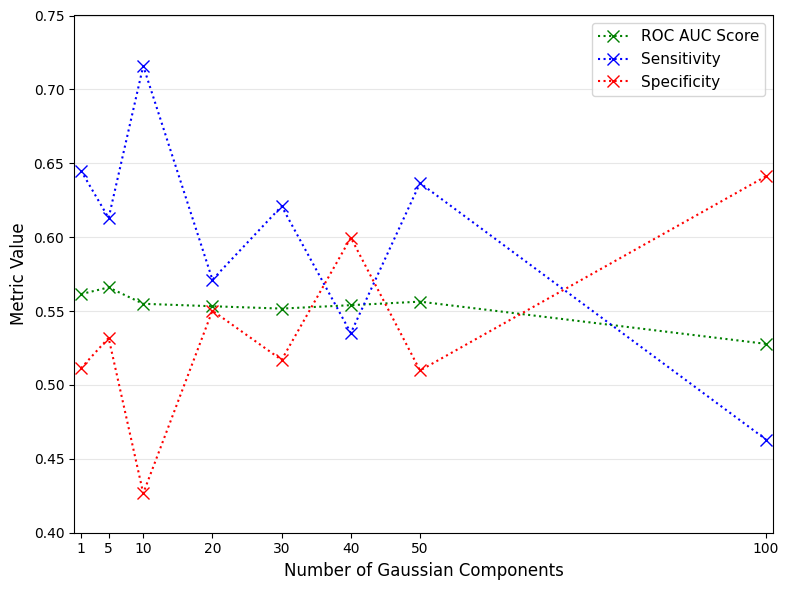

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Number of Gaussian Components', ylabel='Metric Value'>)

In [ ]:
create_styled_plot(
    results_selected,
    x_col='C',
    y_col=['roc_auc_score', 'sensitivity', 'specificity'],
    group_col=None,
    figsize=(8, 6),
    colors=['green', 'blue', 'red'],
    markers=['x'],
    linestyles=['dotted'],
    linewidth=1.5,
    markersize=8,
    xlabel='Number of Gaussian Components',
    ylabel='Metric Value',
    xlim=(0, 101),
    ylim=(0.4, 0.75),
    xticks=[1, 5, 10, 20, 30, 40, 50, 100],
    grid=True,
    grid_alpha=0.3,
    grid_axis='y',
    legend_fontsize=11,
    legend_labels=['ROC AUC Score', 'Sensitivity', 'Specificity'],#['Shift Deviation', 'Abnormal Heading', 'Abnormal Speed'],
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    title_fontsize=14,
    title=None,
    save_path='plots/RQ1/roc-auc-sensitivity-specificity.pdf',
    save_format='pdf',
    #dpi=800,
    show_plot=True,
    tight_layout=True,
    print_stats=False
)

# RQ: 2 Baseline Comparison

## Methods

In [478]:
def compute_diffs(df):
   w_cols = df.xs('w', level=1, axis=1)
   b_cols = df.xs('b', level=1, axis=1)
   diffs = w_cols - b_cols
   diffs.columns = [f'diff_{col}' for col in diffs.columns]
   return pd.concat([df, diffs], axis=1)

In [479]:
def create_comparison_table(df, metrics, index=None):
    """Compute mean per model"""

    pt = df.pivot_table(columns='model_name', values=metrics, aggfunc='mean')
    pt['delta'] = pt['w'] - pt['b']
    return pt

## Data loading

In [480]:
results_2_fp = 'tables/RQ2/rq2_results_all.csv'
results_2_df = pd.read_csv(results_2_fp)

results_2_df['accuracy'] = (results_2_df['tn'] + results_2_df['tp']) / (results_2_df['tn'] + results_2_df['tp'] + results_2_df['fn'] + results_2_df['fp'])

results_2_df['sensitivity'] = 1 - results_2_df['fnr']
results_2_df['specificity'] = 1 - results_2_df['fpr']

results_2_df = results_2_df[results_2_df['threshold_method'] == 'optimal'] # Method for selecting threshold for labelling trajectories as anomalies

results_2_df['d'] = results_2_df['d'].fillna(0.0).astype('int') # Because parameter not existing for type 3 anomalies

print(results_2_df.columns)

Index(['type', 'd', 'r', 'p', 'roc_auc_score', 'threshold', 'tn', 'fp', 'fn',
       'tp', 'fpr', 'fnr', 'precision', 'recall', 'f1_score', 'model_name',
       'threshold_method', 'accuracy', 'sensitivity', 'specificity'],
      dtype='object')


### Test Configuration Representation table
To verify equal number of tests per model. 

In [481]:
results_2_df.pivot_table(index=['type', 'd', 'r', 'p'], values='tn', columns='model_name', aggfunc='count')

model_name        b  w
type d r    p         
1    1 0.05 0.05  1  1
            0.10  1  1
            0.20  1  1
       0.10 0.05  1  1
            0.10  1  1
            0.20  1  1
     2 0.05 0.05  1  1
            0.10  1  1
            0.20  1  1
2    1 0.05 0.05  1  1
            0.10  1  1
            0.20  1  1
       0.10 0.05  1  1
            0.10  1  1
            0.20  1  1
     2 0.05 0.05  1  1
            0.10  1  1
            0.20  1  1
3    0 0.05 0.05  1  1
            0.10  1  1
            0.20  1  1
       0.10 0.05  1  1
            0.10  1  1
            0.20  1  1

## Data Selection
For this experiment, we compare models based on sensitivity. We ensure anomalies are represented equally by setting the experiment parameters according to the following setups:

### Setup A: $d = 2$

Creating larger spatial deviation of original trajectory, making the anomalies more pronounced.

$d = 2$

However, since $d = 2$ we can only set the ratio of anomlies in the test set to,

$r = 0.1$

creating less artificial anomalies in to test.

$\rho \in \{0.05\}$

Experiments for $\rho$ are equally available for all types of anomalies

### Setup B: $d = 1$
For this experiment, we compare models based on sensitivity. We ensure anomalies are represented equally by setting the experiment parameters to:

Setting the spatial deviation of the anomaly with respect to original trajectory to the smalles value, making anomalies harder to detect

$d = 1$

Now that we increased the value for $d$ to $1$ we can use the sets with a larger ratio of anomalies:

$r \in \{0.1\}$

Experiments for $\rho$ are equally available for all types of anomalies

$\rho \in \{0.05\}$

In [139]:
results_2_df_sel_a = results_2_df[(results_2_df['d'].isin([0, 1])) & (results_2_df['r'] == 0.1) & (results_2_df['p'] == 0.05)]
results_2_df_sel_b = results_2_df[(results_2_df['d'].isin([0, 2])) & (results_2_df['r'].isin([0.1])) & (results_2_df['p'] == 0.05)]

## Compare and test Significance of Models

### A

In [141]:
rq2_comp_tab_a = create_comparison_table(results_2_df_sel_a, metrics=['sensitivity', 'specificity', 'roc_auc_score'])
rq2_comp_tab_a

model_name,b,w,delta
roc_auc_score,0.594660,0.585078,-0.009581
sensitivity,0.629026,0.601438,-0.027588
specificity,0.541087,0.578333,0.037246


In [143]:
print(rq2_comp_tab_a)

model_name            b         w     delta
roc_auc_score  0.594660  0.585078 -0.009581
sensitivity    0.629026  0.601438 -0.027588
specificity    0.541087  0.578333  0.037246


### B

In [142]:
rq2_comp_tab_b = create_comparison_table(results_2_df_sel_b, metrics=['sensitivity', 'specificity', 'roc_auc_score'])
rq2_comp_tab_b

model_name,b,w,delta
roc_auc_score,0.622833,0.606709,-0.016124
sensitivity,0.765432,0.703704,-0.061728
specificity,0.452186,0.509563,0.057377


In [144]:
print(rq2_comp_tab_b)

model_name            b         w     delta
roc_auc_score  0.622833  0.606709 -0.016124
sensitivity    0.765432  0.703704 -0.061728
specificity    0.452186  0.509563  0.057377


## Summary Table

In [103]:
pt = results_2_df.pivot_table(index=['d', 'r', 'p'], columns='model_name', values=['specificity'], aggfunc='mean')
pt_diff = compute_diffs(pt)
pt_diff

(specificity, b)  (specificity, w)  diff_specificity
d r    p                                                         
0 0.05 0.05          0.200517          0.807245          0.606727
       0.10          0.406210          0.573092          0.166882
       0.20          0.803364          0.644243         -0.159120
  0.10 0.05          0.452186          0.509563          0.057377
       0.10          0.386612          0.360656         -0.025956
       0.20          0.478142          0.512295          0.034153
1 0.05 0.05          0.506638          0.538457          0.031819
       0.10          0.622956          0.668746          0.045790
       0.20          0.359155          0.348912         -0.010243
  0.10 0.05          0.585538          0.612718          0.027180
       0.10          0.671932          0.729815          0.057883
       0.20          0.703261          0.590163         -0.113097
2 0.05 0.05          0.775923          0.778116          0.002192
       0.10          0.713452          0.844169          0.130717
       0.20          0.787206          0.809043          0.021836

## Significance

In [516]:
rq2_sig_df = results_2_df[(results_2_df['threshold_method'] == 'optimal') & (results_2_df['d'].isin([0,1])) & (results_2_df['p']== 0.05) & (results_2_df['r']== 0.1)]
rq2_sig_df = rq2_sig_df[['model_name', 'type', 'tn', 'fp']]
rq2_sig_df

,model_name,type,tn,fp
27,b,1,521,221
36,b,2,347,393
45,b,3,331,401
75,w,1,437,305
84,w,2,471,269
93,w,3,373,359


In [517]:
# Import library
from statsmodels.stats.contingency_tables import mcnemar


In [518]:
for i in range(1,4):
    tmp_df = rq2_sig_df.copy()
    tmp_df = tmp_df[tmp_df['type'] == i].drop(columns=['type'])
    print(f'Type {i}')
    print(tmp_df)
    data = tmp_df.T.values[1:]
    print(mcnemar(data, exact=True))
    print('\n')

Type 1
   model_name   tn   fp
27          b  521  221
75          w  437  305
pvalue      2.7183369138890812e-17
statistic   221.0


Type 2
   model_name   tn   fp
36          b  347  393
84          w  471  269
pvalue      0.008765209421759644
statistic   393.0


Type 3
   model_name   tn   fp
45          b  331  401
93          w  373  359
pvalue      0.3318029524557352
statistic   373.0




# RQ3: Scores Per Anomaly

*How does weather integration affect the model's ability to correctly identify different types of artificial anomalies while avoiding false positives from weather-induced movements?*

For this RQ we compare the baseline model with the enhanced model for each type of anomaly.

## Methods

In [41]:
def create_comparison_table_multi_index(df, metrics):
    pt = df.pivot_table(index='type', columns='model_name', values=metrics)
    for mt in metrics:
        pt[(mt, 'delta')] = pt[(mt, 'w')] - pt[(mt, 'b')]
    return pt

def filter_for_setup(df, d, r, rho):
    return df[(df['d'].isnin([d])) & (df['d'].isnin([d])) & (df['d'].isnin([d]))]

def compute_diffs(df):
   w_cols = df.xs('w', level=1, axis=1)
   b_cols = df.xs('b', level=1, axis=1)
   diffs = w_cols - b_cols
   diffs.columns = [f'diff_{col}' for col in diffs.columns]
   return pd.concat([df, diffs], axis=1)

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import numpy as np

def compare_models_paired_ttest(df, metrics=['roc_auc_score', 'sensitivity', 'specificity'],
                               alpha=0.05, correction='bonferroni', group_by=None):
    """
    Perform paired t-tests comparing weather model (w) vs baseline model (b) metrics.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns formatted as tuples (metric_name, model_type) or MultiIndex
    metrics : list
        List of metric names to test (default: ['roc_auc_score', 'sensitivity', 'specificity'])
    alpha : float
        Significance level (default: 0.05)
    correction : str
        Multiple comparison correction method ('bonferroni', 'holm', 'fdr_bh', or None)
    group_by : str or None
        Column name to group by for separate analyses (e.g., 'type' for anomaly type)

    Returns:
    --------
    pandas.DataFrame
        Results table with t-statistics, p-values, effect sizes, and significance indicators
    """

    # Handle grouped analysis
    if group_by is not None:
        # Check if group_by column exists in index or columns
        if group_by in df.index.names:
            # Group by index level
            groups = df.groupby(level=group_by)
        elif hasattr(df, 'columns') and group_by in df.columns:
            # Group by column
            groups = df.groupby(group_by)
        else:
            print(f"Warning: Group column '{group_by}' not found")
            groups = [(None, df)]
    else:
        groups = [(None, df)]

    all_results = []

    for group_name, group_df in groups:
        results = []
        p_values = []

        for metric in metrics:
            # Handle MultiIndex columns (for pivot tables)
            if hasattr(group_df.columns, 'nlevels') and group_df.columns.nlevels > 1:
                baseline_col = (metric, 'b')
                weather_col = (metric, 'w')
            else:
                # Handle tuple columns or string columns
                baseline_col = (metric, 'b') if (metric, 'b') in group_df.columns else f'({metric}, b)'
                weather_col = (metric, 'w') if (metric, 'w') in group_df.columns else f'({metric}, w)'

            # Check if columns exist
            if baseline_col not in group_df.columns or weather_col not in group_df.columns:
                print(f"Warning: Columns for {metric} not found in dataframe for group {group_name}")
                continue

            # Get data and remove any NaN values
            baseline_data = group_df[baseline_col].dropna()
            weather_data = group_df[weather_col].dropna()

            # Ensure paired data (same indices)
            common_idx = baseline_data.index.intersection(weather_data.index)
            baseline_data = baseline_data.loc[common_idx]
            weather_data = weather_data.loc[common_idx]

            if len(baseline_data) < 2:
                print(f"Warning: Not enough data points for {metric} in group {group_name}")
                continue

            # Paired t-test
            t_stat, p_value = ttest_rel(weather_data, baseline_data)

            # Effect size (Cohen's d for paired samples)
            diff = weather_data - baseline_data
            cohens_d = np.mean(diff) / np.std(diff, ddof=1)

            # Mean difference
            mean_diff = np.mean(diff)

            result = {
                'group': group_name if group_name is not None else 'All',
                'metric': metric,
                't_statistic': t_stat,
                'p_value': p_value,
                'mean_difference': mean_diff,
                'cohens_d': cohens_d,
                'n_pairs': len(baseline_data)
            }

            results.append(result)
            p_values.append(p_value)

        # Add results for this group
        all_results.extend(results)

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Only proceed if we have valid results
    if results_df.empty:
        print("No valid results found. Check your dataframe columns and metric names.")
        return results_df

    # Apply multiple comparison correction if specified
    if correction and len(results_df) > 1:
        # Group p-values by group for correction
        if group_by is not None:
            corrected_p_values = []
            significant_corrected = []

            for group_name in results_df['group'].unique():
                group_mask = results_df['group'] == group_name
                group_p_values = results_df.loc[group_mask, 'p_value'].values

                if len(group_p_values) > 1:
                    corrected_results = multipletests(group_p_values, method=correction, alpha=alpha)
                    corrected_p_values.extend(corrected_results[1])
                    significant_corrected.extend(corrected_results[0])
                else:
                    corrected_p_values.extend(group_p_values)
                    significant_corrected.extend(group_p_values < alpha)

            results_df['p_adjusted'] = corrected_p_values
            results_df['significant_corrected'] = significant_corrected
        else:
            # Apply correction across all tests
            all_p_values = results_df['p_value'].values
            corrected_results = multipletests(all_p_values, method=correction, alpha=alpha)
            results_df['p_adjusted'] = corrected_results[1]
            results_df['significant_corrected'] = corrected_results[0]

        print(f"Applied {correction} correction for multiple comparisons")

    # Add significance indicators
    results_df['significant'] = results_df['p_value'] < alpha

    # Add interpretation of effect size
    def interpret_cohens_d(d):
        abs_d = abs(d)
        if abs_d < 0.2:
            return 'negligible'
        elif abs_d < 0.5:
            return 'small'
        elif abs_d < 0.8:
            return 'medium'
        else:
            return 'large'

    results_df['effect_size_interpretation'] = results_df['cohens_d'].apply(interpret_cohens_d)

    return results_df

def print_results_summary(results_df):
    """
    Print a formatted summary of the paired t-test results.
    """
    print("=" * 70)
    print("PAIRED T-TEST RESULTS: Weather Model vs Baseline Model")
    print("=" * 70)

    # Group by group column if it exists
    if 'group' in results_df.columns:
        for group_name in results_df['group'].unique():
            group_data = results_df[results_df['group'] == group_name]

            print(f"\n{'GROUP: ' + str(group_name):=^70}")

            for _, row in group_data.iterrows():
                print(f"\n{row['metric'].upper()}:")
                print(f"  Mean difference (w - b): {row['mean_difference']:+.4f}")
                print(f"  t-statistic: {row['t_statistic']:+.4f}")
                print(f"  p-value: {row['p_value']:.4f}")
                print(f"  Sample size: {row['n_pairs']}")

                if 'p_adjusted' in results_df.columns:
                    print(f"  p-value (adjusted): {row['p_adjusted']:.4f}")
                    significance = "YES" if row['significant_corrected'] else "NO"
                    print(f"  Significant (corrected): {significance}")
                else:
                    significance = "YES" if row['significant'] else "NO"
                    print(f"  Significant: {significance}")

                print(f"  Effect size (Cohen's d): {row['cohens_d']:+.4f} ({row['effect_size_interpretation']})")

                # Interpretation
                if row['mean_difference'] > 0:
                    direction = "BETTER"
                elif row['mean_difference'] < 0:
                    direction = "WORSE"
                else:
                    direction = "SAME"
                print(f"  → Weather model performs {direction} than baseline")
    else:
        # Original format for non-grouped results
        for _, row in results_df.iterrows():
            print(f"\n{row['metric'].upper()}:")
            print(f"  Mean difference (w - b): {row['mean_difference']:+.4f}")
            print(f"  t-statistic: {row['t_statistic']:+.4f}")
            print(f"  p-value: {row['p_value']:.4f}")

            if 'p_adjusted' in results_df.columns:
                print(f"  p-value (adjusted): {row['p_adjusted']:.4f}")
                significance = "YES" if row['significant_corrected'] else "NO"
                print(f"  Significant (corrected): {significance}")
            else:
                significance = "YES" if row['significant'] else "NO"
                print(f"  Significant: {significance}")

            print(f"  Effect size (Cohen's d): {row['cohens_d']:+.4f} ({row['effect_size_interpretation']})")

            # Interpretation
            if row['mean_difference'] > 0:
                direction = "BETTER"
            elif row['mean_difference'] < 0:
                direction = "WORSE"
            else:
                direction = "SAME"
            print(f"  → Weather model performs {direction} than baseline")

## Data Selection

In [189]:
results_3_df = results_2_df.copy()
# results_3_df = (results_3_df[(results_3_df['d'].isin([0, 1])) & (results_3_df['r'] == 0.1)])

In [173]:
results_3_df.head()

,type,d,r,p,roc_auc_score,threshold,tn,fp,fn,tp,fpr,fnr,precision,recall,f1_score,model_name,threshold_method,accuracy,sensitivity,specificity
27,1,1,0.1,0.05,0.618480,25.334631,521,221,41,39,0.297844,0.512500,0.150000,0.487500,0.229412,b,optimal,0.681265,0.487500,0.702156
28,1,1,0.1,0.10,0.551440,23.367907,408,324,35,46,0.442623,0.432099,0.124324,0.567901,0.203991,b,optimal,0.558426,0.567901,0.557377
29,1,1,0.1,0.20,0.624840,24.401073,468,266,34,45,0.362398,0.430380,0.144695,0.569620,0.230769,b,optimal,0.630996,0.569620,0.637602
36,2,1,0.1,0.05,0.542666,22.335360,347,393,30,52,0.531081,0.365854,0.116854,0.634146,0.197343,b,optimal,0.485401,0.634146,0.468919
37,2,1,0.1,0.10,0.678790,26.737749,582,158,41,41,0.213514,0.500000,0.206030,0.500000,0.291815,b,optimal,0.757908,0.500000,0.786486


In [191]:
rq3_df_t1 = results_3_df[results_3_df['type'] == 1]
rq3_df_t2 = results_3_df[results_3_df['type'] == 2]
rq3_df_t3 = results_3_df[results_3_df['type'] == 3]

## Global Comparison Table

In [275]:
rq3_pt_global = (results_3_df[(results_3_df['d'].isin([0, 1])) & (results_3_df['r'] == 0.1) & (results_3_df['p'] == 0.05)])
rq3_pt_global = rq3_pt_global.pivot_table(index='type', columns='model_name', values=['roc_auc_score', 'sensitivity', 'specificity'])
compute_diffs(rq3_pt_global)

,"(roc_auc_score, b)","(roc_auc_score, w)","(sensitivity, b)","(sensitivity, w)","(specificity, b)","(specificity, w)",diff_roc_auc_score,diff_sensitivity,diff_specificity
type,,,,,,,,,
1,0.618480,0.614067,0.487500,0.625000,0.702156,0.588949,-0.004414,0.137500,-0.113208
2,0.542666,0.534459,0.634146,0.475610,0.468919,0.636486,-0.008207,-0.158537,0.167568
3,0.622833,0.606709,0.765432,0.703704,0.452186,0.509563,-0.016124,-0.061728,0.057377


## Anomalies of type 1: Shift Deviation

In [194]:
pt1 = rq3_df_t1.pivot_table(index=['d', 'r', 'p'], values=['roc_auc_score', 'sensitivity', 'specificity'], columns='model_name')
compute_diffs(pt1)

(roc_auc_score, b)  (roc_auc_score, w)  (sensitivity, b)  \
d r    p                                                                
1 0.05 0.05            0.610714            0.622143          0.615385   
       0.10            0.588087            0.588584          0.769231   
       0.20            0.568065            0.557072          0.731707   
  0.10 0.05            0.618480            0.614067          0.487500   
       0.10            0.551440            0.559452          0.567901   
       0.20            0.624840            0.620477          0.569620   
2 0.05 0.05            0.727038            0.719114          0.625000   
       0.10            0.756113            0.780239          0.725000   
       0.20            0.684456            0.696283          0.512821   

             (sensitivity, w)  (specificity, b)  (specificity, w)  \
d r    p                                                            
1 0.05 0.05          0.666667          0.624031          0.581395   
       0.10          0.692308          0.436693          0.511628   
       0.20          0.731707          0.414853          0.375160   
  0.10 0.05          0.625000          0.702156          0.588949   
       0.10          0.481481          0.557377          0.640710   
       0.20          0.632911          0.637602          0.573569   
2 0.05 0.05          0.550000          0.749030          0.802070   
       0.10          0.650000          0.676585          0.824062   
       0.20          0.564103          0.802326          0.817829   

             diff_roc_auc_score  diff_sensitivity  diff_specificity  
d r    p                                                             
1 0.05 0.05            0.011429          0.051282         -0.042636  
       0.10            0.000497         -0.076923          0.074935  
       0.20           -0.010993          0.000000         -0.039693  
  0.10 0.05           -0.004414          0.137500         -0.113208  
       0.10            0.008011         -0.086420          0.083333  
       0.20           -0.004363          0.063291         -0.064033  
2 0.05 0.05           -0.007924         -0.075000          0.053040  
       0.10            0.024127         -0.075000          0.147477  
       0.20            0.011827          0.051282          0.015504

## Anomalies of type 2: Abnormal Heading

In [198]:
pt2 = rq3_df_t2.pivot_table(index=['d', 'r', 'p'], values=['roc_auc_score', 'sensitivity', 'specificity'], columns='model_name')
compute_diffs(pt2)#.to_csv('tables/RQ3/type-2.csv', float_format='%.4f')

(roc_auc_score, b)  (roc_auc_score, w)  (sensitivity, b)  \
d r    p                                                                
1 0.05 0.05            0.607320            0.609381          0.829268   
       0.10            0.627057            0.608975          0.414634   
       0.20            0.622310            0.649261          0.951220   
  0.10 0.05            0.542666            0.534459          0.634146   
       0.10            0.678790            0.682993          0.500000   
       0.20            0.743425            0.753972          0.609756   
2 0.05 0.05            0.853565            0.855564          0.853659   
       0.10            0.849099            0.863996          0.804878   
       0.20            0.889541            0.872271          0.902439   

             (sensitivity, w)  (specificity, b)  (specificity, w)  \
d r    p                                                            
1 0.05 0.05          0.707317          0.389245          0.495519   
       0.10          0.390244          0.809219          0.825864   
       0.20          0.926829          0.303457          0.322663   
  0.10 0.05          0.475610          0.468919          0.636486   
       0.10          0.500000          0.786486          0.818919   
       0.20          0.804878          0.768919          0.606757   
2 0.05 0.05          0.902439          0.802817          0.754161   
       0.10          0.731707          0.750320          0.864277   
       0.20          0.829268          0.772087          0.800256   

             diff_roc_auc_score  diff_sensitivity  diff_specificity  
d r    p                                                             
1 0.05 0.05            0.002061         -0.121951          0.106274  
       0.10           -0.018082         -0.024390          0.016645  
       0.20            0.026951         -0.024390          0.019206  
  0.10 0.05           -0.008207         -0.158537          0.167568  
       0.10            0.004202          0.000000          0.032432  
       0.20            0.010547          0.195122         -0.162162  
2 0.05 0.05            0.001999          0.048780         -0.048656  
       0.10            0.014896         -0.073171          0.113956  
       0.20           -0.017270         -0.073171          0.028169

## Anomalies of type 3: Abnormal Speeding

In [200]:
pt3 = rq3_df_t3.pivot_table(index=['d', 'r', 'p'], values=['roc_auc_score', 'sensitivity', 'specificity'], columns='model_name')
compute_diffs(pt3).to_csv('tables/RQ3/type-3.csv', float_format='%.4f')

# RQ: 4 Weather Severity

## Methods

In [451]:
def compute_wind_spd(u10, v10):
    return np.sqrt(u10**2 + v10**2)

def create_weather_agg(row):
    return row['swh'] + compute_wind_spd(row['u10'], row['v10'])

In [452]:
def calc_roc_auc_score(x):
    return roc_auc_score(x['label'], x['loss'])

In [ ]:
def find_optimal_threshold(y_true, y_score):
    """
    Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # Youden's J = Sensitivity + Specificity - 1 = TPR - FPR
    j_scores = tpr - fpr - 1
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

## Data Loading

### Weather Enriched Test Set

In [454]:
test_df = pd.read_parquet('../../enrich-ais-metocean/stad/joined-stad-weather-test.parquet')

In [455]:
test_df.head()

,latitude,longitude,SOG,COG,timestamp,MMSI,traj_id,swh,mwd,mwp,u10,v10
0,37.5945,-123.0155,10.300000,237.500000,1693526406,369037000,369037000_0,2.631632,309.778809,7.228070,9.627502,-8.796371
1,37.5785,-123.0435,9.600000,235.068852,1693527006,369037000,369037000_0,2.631632,309.778809,7.228070,8.520081,-8.645981
2,37.5635,-123.0705,8.762121,248.145455,1693527606,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559
3,37.5605,-123.0995,8.684058,267.317391,1693528206,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559
4,37.5605,-123.1305,8.540580,269.252174,1693528806,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559


### Loss Scores

In [456]:
fp_w = 'tables/RQ4/rq4_unreduced_model_name_w.csv'
fp_b = 'tables/RQ4/rq4_unreduced_model_name_b.csv'

df1 = pd.read_csv(fp_w)
df2 = pd.read_csv(fp_b)

df_loss = pd.concat([df1, df2], axis=0)

df_loss['label'] = df_loss['label'].astype('int')
df_loss['d'] = df_loss['d'].fillna(0.0).astype('int')

print(df_loss.shape)

df_loss.head()

(39222, 8)


,type,d,r,p,tid,label,loss,model_name
0,1,1,0.05,0.05,369037000_0,0,21.786413,w
1,1,1,0.05,0.05,369037000_1,0,23.780455,w
2,1,1,0.05,0.05,369037000_2,0,32.135002,w
3,1,1,0.05,0.05,477637600_3,0,38.639095,w
4,1,1,0.05,0.05,477637600_4,0,24.733644,w


## Data Preparation

### Weather Enriched Test Set

#### Compute Wind Speed

In [457]:
test_df['wspeed'] = compute_wind_spd(test_df['u10'], test_df['v10'])

#### Create Weather Aggregation Statistic

##### Analyse Distribution of Meteorological Data

In [458]:
test_df['wspeed'].describe()

count    91508.000000
mean         5.564400
std          3.221117
min          0.021393
25%          2.903170
50%          4.889442
75%          7.963941
max         15.628021
Name: wspeed, dtype: float64

<Axes: ylabel='Density'>

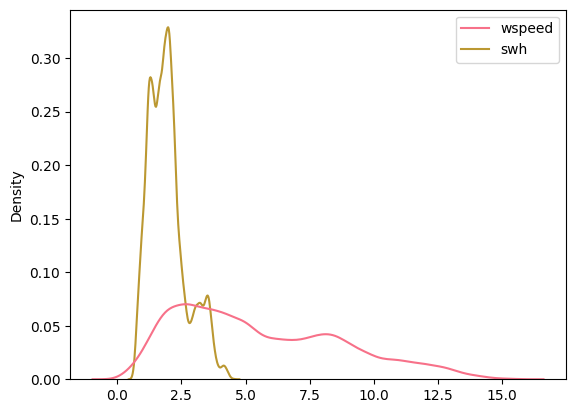

In [459]:
sns.kdeplot([test_df['wspeed'], test_df['swh']])

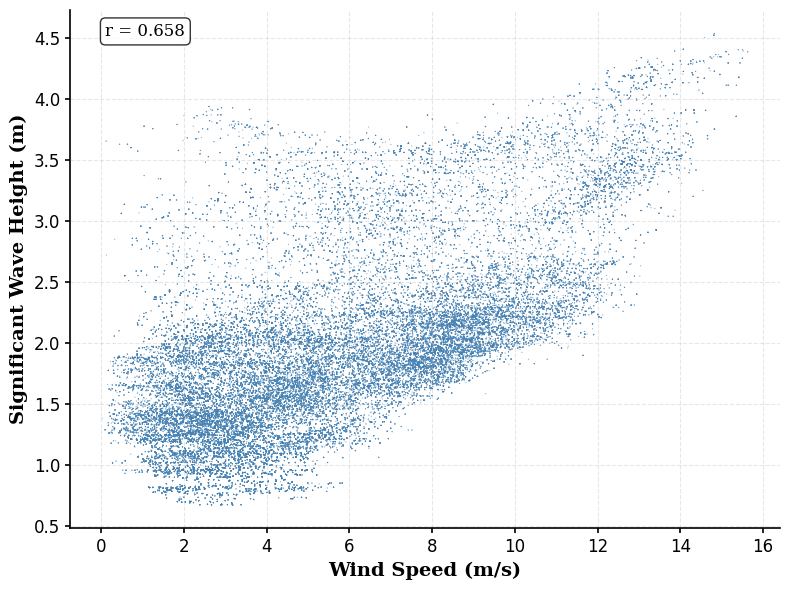

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(test_df['wspeed'],
           test_df['swh'],
           s=0.8,
           alpha=0.6,
           c='steelblue',
           edgecolors='none')

ax.set_xlabel('Wind Speed (m/s)', fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel('Significant Wave Height (m)', fontsize=14, fontweight='bold', fontfamily='serif')
# ax.set_title('Relationship between Wind Speed and Significant Wave Height',
#              fontsize=16, fontweight='bold', pad=20, fontfamily='serif')

ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)

correlation = np.corrcoef(test_df['wspeed'], test_df['swh'])[0,1]
ax.text(0.05, 0.95, f'r = {correlation:.3f}',
        transform=ax.transAxes, fontsize=12, fontfamily='serif',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


# plt.savefig('plots/RQ4/scatter_thesis.pdf', bbox_inches='tight',
#             facecolor='white', edgecolor='none')
plt.tight_layout()
plt.show()

In [362]:
# This returns both correlation coefficient and p-value
correlation, p_value = stats.pearsonr(test_df['swh'], test_df['wspeed'])
print(f"Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.6f}")

Correlation: 0.658
P-value: 0.000000


In [363]:
test_df['weather_agg'] = test_df[['swh', 'u10', 'v10']].apply(create_weather_agg, axis=1)

In [364]:
trj_max_weather = test_df.groupby('traj_id')['weather_agg'].max()

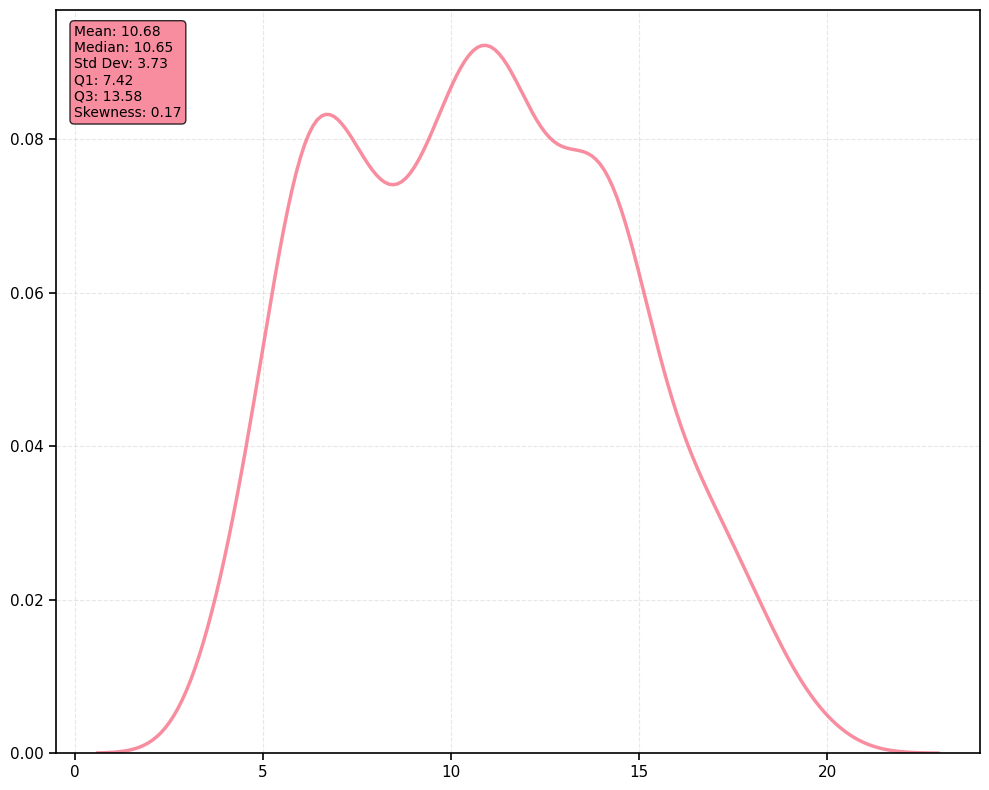

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set the style for publication-quality plots
plt.style.use('default')
sns.set_palette("husl")

# Create figure with specific size for thesis
fig, ax = plt.subplots(figsize=(10, 8))

# Create KDE plots with enhanced styling
# sns.kdeplot(data=test_df['wspeed'],
#            label='Wind Speed (m/s)',
#            linewidth=2.5,
#            alpha=0.8,
#            ax=ax)

# sns.kdeplot(data=test_df['swh'],
#            label='Wave Height (m)',
#            linewidth=2.5,
#            alpha=0.8,
#            ax=ax)

sns.kdeplot(data=trj_max_weather,
           label='Sum of Maximum Wind Speed (m/s) and \n Significant Wave Height',
           linewidth=2.5,
           alpha=0.8,
           ax=ax)

# Calculate statistics
mean_val = np.mean(trj_max_weather)
median_val = np.median(trj_max_weather)
std_val = np.std(trj_max_weather)
q1 = np.percentile(trj_max_weather, 25)
q3 = np.percentile(trj_max_weather, 75)
skewness = stats.skew(trj_max_weather)

# Create statistics text box
stats_text = f''
stats_text += f'Mean: {mean_val:.2f}\n'
stats_text += f'Median: {median_val:.2f}\n'
stats_text += f'Std Dev: {std_val:.2f}\n'
stats_text += f'Q1: {q1:.2f}\n'
stats_text += f'Q3: {q3:.2f}\n'
stats_text += f'Skewness: {skewness:.2f}'

# Add statistics box
props = dict(boxstyle='round', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Customize the plot for thesis presentation
ax.set_xlabel(None, fontsize=14, fontweight='bold')
ax.set_ylabel(None, fontsize=14, fontweight='bold')
# ax.set_title('Kernel Density Estimation: Wind Speed vs Significant Wave Height',
#              fontsize=16, fontweight='bold', pad=20)

# Enhance legend
# ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True,
#           loc='upper right', framealpha=0.9)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=11,
               width=1.2, length=5)
ax.tick_params(axis='both', which='minor', width=0.8, length=3)

# Set spine properties
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('black')

# Adjust layout to prevent clipping
plt.tight_layout()

# Optional: Add statistical information as text box
# You can uncomment and modify this section if needed
# textstr = f'Wind Speed: μ={test_df["wspeed"].mean():.2f}, σ={test_df["wspeed"].std():.2f}\n'
# textstr += f'Wave Height: μ={test_df["swh"].mean():.2f}, σ={test_df["swh"].std():.2f}'
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
# ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
#         verticalalignment='top', bbox=props)

# Save the plot in high resolution for thesis
# plt.savefig('kde_plot_thesis.png', dpi=300, bbox_inches='tight',
#             facecolor='white', edgecolor='none')
plt.savefig('kde_plot_thesis.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

In [349]:
stats.skewtest(trj_max_weather)

SkewtestResult(statistic=np.float64(1.972700258041838), pvalue=np.float64(0.04852972255794313))

In [291]:
bins = [trj_max_weather.min(), trj_max_weather.median(), trj_max_weather.max()]
print(bins)

[3.5362906455993652, 10.648661613464355, 20.012096405029297]


In [292]:
labels = ['Below Average', 'Above Average']
categorized_trjs = pd.cut(trj_max_weather, bins=bins, labels=labels, include_lowest=True)

In [293]:
categorized_trjs.value_counts()

weather_agg
Below Average    407
Above Average    406
Name: count, dtype: int64

<Axes: xlabel='weather_agg', ylabel='Density'>

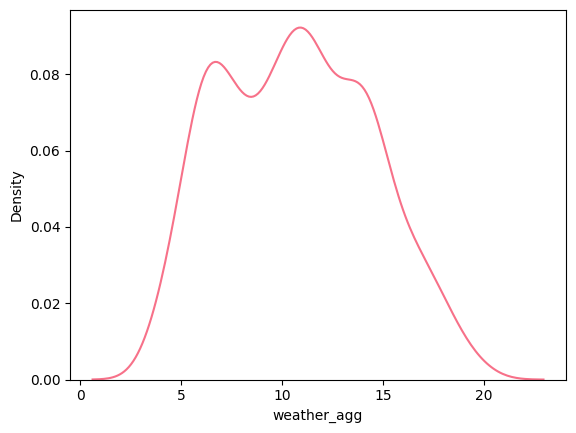

In [294]:
sns.kdeplot(trj_max_weather)

## Categorize Trajectories in Test Set based on Weather Severity

In [474]:
df_loss_w = df_loss.merge(right=categorized_trjs, right_index=True, left_on='tid', how='left').dropna(subset='weather_agg')

In [461]:
df_loss_w.head()

,type,d,r,p,tid,label,loss,model_name,weather_agg
0,1,1,0.05,0.05,369037000_0,0,21.786413,w,Above Average
1,1,1,0.05,0.05,369037000_1,0,23.780455,w,Above Average
2,1,1,0.05,0.05,369037000_2,0,32.135002,w,Below Average
3,1,1,0.05,0.05,477637600_3,0,38.639095,w,Below Average
4,1,1,0.05,0.05,477637600_4,0,24.733644,w,Below Average


In [ ]:
# df_loss_selected = df_loss_w[df_loss_w['model_name'] == 'w'].drop(columns=['model_name'])

df_loss_selected = (df_loss_w[(df_loss_w['d'].isin([0, 1]))
                                      & (df_loss_w['r'].isin([0.1]))
                                      & (df_loss_w['p'].isin([0.05]))])

df_loss_selected

,type,d,r,p,tid,label,loss,model_name,weather_agg
2448,1,1,0.1,0.05,369037000_0,0,21.786413,w,Above Average
2449,1,1,0.1,0.05,369037000_1,0,23.780455,w,Above Average
2450,1,1,0.1,0.05,369037000_2,0,32.135002,w,Below Average
2451,1,1,0.1,0.05,477637600_3,1,38.639095,w,Below Average
2452,1,1,0.1,0.05,477637600_4,0,24.733644,w,Below Average
...,...,...,...,...,...,...,...,...,...
17980,3,0,0.1,0.05,538005129_808,0,20.693031,b,Above Average
17981,3,0,0.1,0.05,563062300_809,0,20.953270,b,Above Average
17982,3,0,0.1,0.05,255806187_810,0,16.927105,b,Above Average
17983,3,0,0.1,0.05,235009240_811,0,17.075361,b,Above Average


In [465]:
df_loss_selected.groupby(['type', 'weather_agg']).apply(
    lambda x: roc_auc_score(x['label'], x['loss'])
)

/scratch-node/20230379.3060677/ipykernel_410190/1047456710.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_loss_selected.groupby(['type', 'weather_agg']).apply(
/scratch-node/20230379.3060677/ipykernel_410190/1047456710.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_loss_selected.groupby(['type', 'weather_agg']).apply(


type  weather_agg  
1     Below Average    0.633824
      Above Average    0.697492
2     Below Average    0.535294
      Above Average    0.645161
3     Below Average    0.569434
      Above Average    0.647623
dtype: float64

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np

def calculate_metrics(group):
    y_true = group['label']
    y_score = group['loss']

    # Calculate AUC
    auc = roc_auc_score(y_true, y_score)

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_true, y_score)

    # Calculate sensitivity and specificity at optimal threshold
    y_pred = (y_score >= optimal_threshold).astype(int)

    # True positives, false positives, true negatives, false negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return pd.Series({
        'auc': auc,
        'optimal_threshold': optimal_threshold,
        'sensitivity': sensitivity,
        'specificity': specificity
    })

# Apply the function
results = df_loss_selected.groupby(['type', 'weather_agg']).apply(calculate_metrics)
print(results)

                         auc  optimal_threshold  sensitivity  specificity
type weather_agg                                                         
1    Below Average  0.633824          25.973381     0.600000     0.705882
     Above Average  0.697492          27.212616     0.545455     0.810345
2    Below Average  0.535294          25.100815     0.600000     0.602941
     Above Average  0.645161          23.824390     0.857143     0.564516
3    Below Average  0.569434          22.968019     0.659091     0.498623
     Above Average  0.647623          24.769823     0.648649     0.653117


/scratch-node/20230379.3060677/ipykernel_410190/2006738669.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df_loss_selected.groupby(['type', 'weather_agg']).apply(calculate_metrics)
/scratch-node/20230379.3060677/ipykernel_410190/2006738669.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_loss_selected.groupby(['type', 'weather_agg']).apply(calculate_metrics)


In [468]:
df_loss_w

losses_weather_above = df_loss_w[df_loss_w['weather_agg'] == 'Above Average']

Test if the loss scores for the negative class test significantly different as compared to the model without weather

In [ ]:
from scipy.stats import wilcoxon, mannwhitneyu
import numpy as np

for w_agg in ['Below Average', 'Above Average']:

    df_wagg = df_loss_w[df_loss_w['weather_agg'] == w_agg]

    print(w_agg)

    for i in range(1,4):
        print(f'type {i}')
        tmp_set = df_wagg.copy()
        tmp_set = tmp_set[tmp_set['type'] == i]
        tmp_set = tmp_set[tmp_set['label'] == 0]

        # Your performance data (example)
        model_a_scores = tmp_set[tmp_set['model_name'] == 'w']['loss']
        model_b_scores = tmp_set[tmp_set['model_name'] == 'b']['loss'] # baseline model

        # Perform Wilcoxon signed-rank test
        statistic, p_value = mannwhitneyu(model_a_scores, model_b_scores,
                                     alternative='two-sided')



        print(f"Test statistic: {statistic}")
        print(f"p-value: {p_value}")


Below Average
type 1
Test statistic: 4004798.0
p-value: 0.4276995323255929
type 2
Test statistic: 220032.0
p-value: 0.47846010599653166
type 3
Test statistic: 2582565.0
p-value: 0.5120007428216988
Above Average
type 1
Test statistic: 3869144.0
p-value: 0.8447949914603339
type 2
Test statistic: 169939.0
p-value: 0.9199199359626751
type 3
Test statistic: 2542023.0
p-value: 0.991076240442056


## Compute Metrics per Test Setup

### Methods

In [ ]:
def find_optimal_threshold(y_true, y_score):
    """
    Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # Youden's J = Sensitivity + Specificity - 1 = TPR - FPR
    j_scores = tpr - fpr - 1
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

## Compare

### Methods

In [ ]:
def paired_weather_ttest(pivot_df, alpha=0.05):
    """
    Perform paired t-test comparing Above Average vs Below Average weather conditions.

    Args:
        pivot_df: DataFrame with weather_agg as index and models as columns
        alpha: significance level (default 0.05)

    Returns:
        dict: results containing t-statistic, p-value, significance, and mean difference
    """
    # Extract scores for each weather condition
    below_scores = pivot_df.loc['Below Average'].values
    above_scores = pivot_df.loc['Above Average'].values

    # Paired t-test
    t_stat, p_value = stats.ttest_rel(above_scores, below_scores)
    mean_diff = np.mean(above_scores) - np.mean(below_scores)

    # Print results
    print(f"Paired t-test (Above Average vs Below Average):")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant difference: {p_value < alpha}")
    print(f"Mean difference: {mean_diff:.6f}")

    # Return results as dictionary
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'mean_difference': mean_diff,
        'alpha': alpha
    }

### Compute ROC AUC per experiment

In [436]:
aggregated = (df_loss_w
 .groupby(['model_name', 'type', 'd', 'r', 'p', 'weather_agg'])
 .apply(calc_roc_auc_score)
 .reset_index()
 .rename({0: 'roc_auc_score'}, axis=1)
             )

aggregated.head()

/scratch-node/20230379.3060677/ipykernel_410190/2053349188.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['model_name', 'type', 'd', 'r', 'p', 'weather_agg'])
/scratch-node/20230379.3060677/ipykernel_410190/2053349188.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calc_roc_auc_score)


,model_name,type,d,r,p,weather_agg,roc_auc_score
0,b,1,1,0.05,0.05,Below Average,0.590568
1,b,1,1,0.05,0.05,Above Average,0.627363
2,b,1,1,0.05,0.10,Below Average,0.596124
3,b,1,1,0.05,0.10,Above Average,0.582619
4,b,1,1,0.05,0.20,Below Average,0.610959


### Ensure Equal Representation of Anomalies
Because the test setups for each type of anomaly are not equally represented. We must apply filter to ensure each type of anomaly is equally represented before we can draw conclusions.

**Setup A:**

$d = 1 $ (For anomalies of type 1 and 2)

and

$d = 0 $ (For anomalies of type 3)

$r = 0.1$

$\rho \in \{0.05, 0.1, 0.2\}$

**Setup B:**

$d = 2 $ (For anomalies of type 1 and 2)

and

$d = 0 $ (For anomalies of type 3)

$r = 0.1$

$\rho \in \{0.05, 0.1, 0.2\}$

**Setup C:**

$d = 2 $ (For anomalies of type 1 and 2)

and

$d = 0 $ (For anomalies of type 3)

$r = 0.1$

$\rho \in \{0.05, 0.1, 0.2\}$

**Setup D:**

$d = 1 $ (For anomalies of type 1 and 2)

and

$d = 0 $ (For anomalies of type 3)

$r = 0.1$

$\rho \in \{0.2\}$

In [254]:
rq4_df_a = aggregated[(aggregated['d'].isin([0, 1])) & (aggregated['r'].isin([0.1])) & (aggregated['p'].isin([0.05, 0.1, 0.2]))]
rq4_df_b = aggregated[(aggregated['d'].isin([0, 2])) & (aggregated['r'].isin([0.1])) & (aggregated['p'].isin([0.05, 0.1, 0.2]))]
rq4_df_c = aggregated[(aggregated['d'].isin([0, 2])) & (aggregated['r'].isin([0.1])) & (aggregated['p'].isin([0.2]))]
rq4_df_d = aggregated[(aggregated['d'].isin([0, 1])) & (aggregated['r'].isin([0.1])) & (aggregated['p'].isin([0.2]))]

In [477]:
rq4_selected = aggregated[(aggregated['d'].isin([0, 1])) & (aggregated['r'].isin([0.1])) & (aggregated['p'].isin([0.05]))]

In [450]:
rq4_selected = rq4_selected[rq4_selected['weather_agg'] == 'Above Average']
rq4_selected = rq4_selected.sort_values(by=['type', 'model_name'])
rq4_selected

,model_name,type,d,r,p,weather_agg,roc_auc_score
7,b,1,1,0.1,0.05,Above Average,0.678683
55,w,1,1,0.1,0.05,Above Average,0.697492
25,b,2,1,0.1,0.05,Above Average,0.686636
73,w,2,1,0.1,0.05,Above Average,0.645161
43,b,3,0,0.1,0.05,Above Average,0.655900
91,w,3,0,0.1,0.05,Above Average,0.647623


In [449]:
pt = rq4_selected.pivot_table(index=['weather_agg', 'd', 'p', 'r'], columns='model_name', values='roc_auc_score')
pt


# values_b = rq4_selected[(rq4_selected['model_name'] == 'b') & (rq4_selected['weather_agg'] == 'Above Average')][['type', 'roc_auc_score']]
# values_w = rq4_selected[(rq4_selected['model_name'] == 'w') & (rq4_selected['weather_agg'] == 'Above Average')][['type', 'roc_auc_score']]

# print(values_b, values_w)
# values_b = pt['b'].loc['Above Average'].values
# values_w = pt['w'].loc['Above Average'].values

/scratch-node/20230379.3060677/ipykernel_410190/2137730526.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pt = rq4_selected.pivot_table(index=['weather_agg', 'd', 'p', 'r'], columns='model_name', values='roc_auc_score')


model_name                       b         w
weather_agg   d p    r                      
Below Average 0 0.05 0.1  0.594227  0.569434
              1 0.05 0.1  0.549265  0.584559
Above Average 0 0.05 0.1  0.655900  0.647623
              1 0.05 0.1  0.682660  0.671327

In [447]:
values_b

,type,roc_auc_score
7,1,0.678683
25,2,0.686636
43,3,0.655900


In [448]:
values_w

,type,roc_auc_score
55,1,0.697492
73,2,0.645161
91,3,0.647623


In [ ]:
from scipy.stats import wilcoxon
import numpy as np

# Your performance data (example)
model_a_scores = values_w
model_b_scores = values_b # baseline model

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(model_a_scores, model_b_scores,
                             alternative='two-sided')

print(f"Test statistic: {statistic}")
print(f"p-value: {p_value}")

Test statistic: [0. 2.]
p-value: [1.   0.75]


/home/20230379/.local/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in divide
  z = (r_plus - mn) / se


In [ ]:
for t in range(1,4):
    b = values_b[values_b['type'] == t]['roc_auc_score'].values
    w = values_w[values_w['type'] == t]['roc_auc_score'].values

    print(b, w)

    # Perform Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(b, w,
                                 alternative='two-sided')

    print(f"Test statistic: {statistic}")
    print(f"p-value: {p_value}")

[0.67868339] [0.69749216]
Test statistic: 0.0
p-value: 1.0
[0.68663594] [0.64516129]
Test statistic: 0.0
p-value: 1.0
[0.6558998] [0.64762323]
Test statistic: 0.0
p-value: 1.0


# Methods: Distribution of Anomaly Scores for the Negative Class

## Methods

In [ ]:
from scipy import stats

def is_normal(data, alpha=0.05):

    # Remove NaN values
    clean_data = data.dropna() if hasattr(data, 'dropna') else data[~pd.isna(data)]

    # Shapiro-Wilk test
    _, p_value = stats.shapiro(clean_data)

    return p_value > alpha, p_value

import pandas as pd
from scipy import stats

def check_normality_by_groups(df, group_cols=['model_name', 'type', 'd', 'r', 'p'],
                             value_col='loss', label_col='label', target_label=0, alpha=0.05):

    # Filter for negative class only
    negative_data = df[df[label_col] == target_label]

    # Group and test normality
    results = []

    for group_name, group_data in negative_data.groupby(group_cols):
        loss_values = group_data[value_col].dropna()

        # Shapiro-Wilk test
        _, p_value = stats.shapiro(loss_values)
        is_normal = p_value > alpha

        # Create result row
        result = dict(zip(group_cols, group_name))
        result.update({
            'n_samples': len(loss_values),
            'is_normal': is_normal,
            'p_value': p_value,
            'mean': loss_values.mean(),
            'std': loss_values.std()
        })
        results.append(result)

    return pd.DataFrame(results)

## Data Loading

In [83]:
fp_w = 'tables/RQ4/rq4_unreduced_model_name_w.csv'
fp_b = 'tables/RQ4/rq4_unreduced_model_name_b.csv'

df1 = pd.read_csv(fp_w)
df2 = pd.read_csv(fp_b)

df_loss = pd.concat([df1, df2], axis=0)

df_loss['label'] = df_loss['label'].astype('int')

In [84]:
print(df_loss.head())

   type    d     r     p          tid  label       loss model_name
0     1  1.0  0.05  0.05  369037000_0      0  21.786413          w
1     1  1.0  0.05  0.05  369037000_1      0  23.780455          w
2     1  1.0  0.05  0.05  369037000_2      0  32.135002          w
3     1  1.0  0.05  0.05  477637600_3      0  38.639095          w
4     1  1.0  0.05  0.05  477637600_4      0  24.733644          w


## Visualize

<Axes: ylabel='loss'>

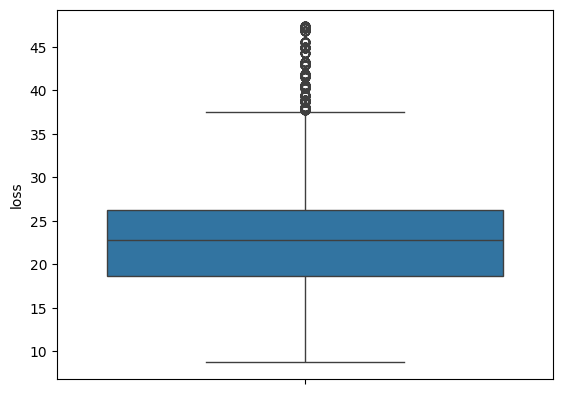

In [85]:
sns.boxplot(
    data=df_loss[df_loss['label'] == 0]['loss']
)

<Axes: xlabel='loss', ylabel='Density'>

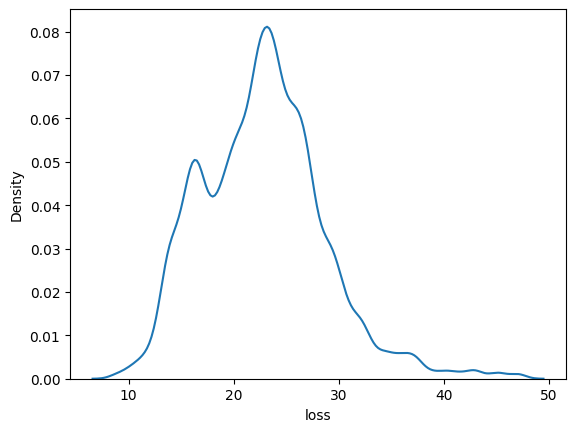

In [86]:
sns.kdeplot(
    data=df_loss[df_loss['label'] == 0]['loss']
)